In [ ]:
import os
from glob import glob
import pandas as pd
from tensorflow.keras.preprocessing import image

In [ ]:
data_dir = "/content/drive/MyDrive/4.2/project/plantvillage"

In [ ]:
classes = os.listdir(data_dir)
classes

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
df = []
for label, class_name in enumerate(classes):
  path = f"{data_dir}/{class_name}"
  for file in os.listdir(path):
     df.append([f'{class_name}/{file}', label, class_name])

In [ ]:
df = pd.DataFrame(df, columns=['file', 'label', 'class_name'])

In [ ]:
df.to_csv("/content/drive/MyDrive/4.2/final/plantVillage.csv")

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/4.2/final/plantVillage.csv")

In [ ]:
df.head()

,Unnamed: 0,file,label,class_name
0,0,Tomato___Bacterial_spot/ae471cad-5e5b-4325-a83...,0,Tomato___Bacterial_spot
1,1,Tomato___Bacterial_spot/689d9301-7023-4488-9c9...,0,Tomato___Bacterial_spot
2,2,Tomato___Bacterial_spot/e28da6e4-81ad-42ff-ad1...,0,Tomato___Bacterial_spot
3,3,Tomato___Bacterial_spot/e4ea3383-b5fc-45b6-a58...,0,Tomato___Bacterial_spot
4,4,Tomato___Bacterial_spot/dcc6402f-a868-4766-9e4...,0,Tomato___Bacterial_spot


In [ ]:
df.shape

(14529, 4)

In [ ]:
def read_img(filepath, size):
  img = image.load_img(data_dir+'/'+filepath, target_size=size)
  img = image.img_to_array(img)
  return img

In [ ]:
import re

In [ ]:
def format_name(s):
   return re.sub('_+', ' ', s)

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt

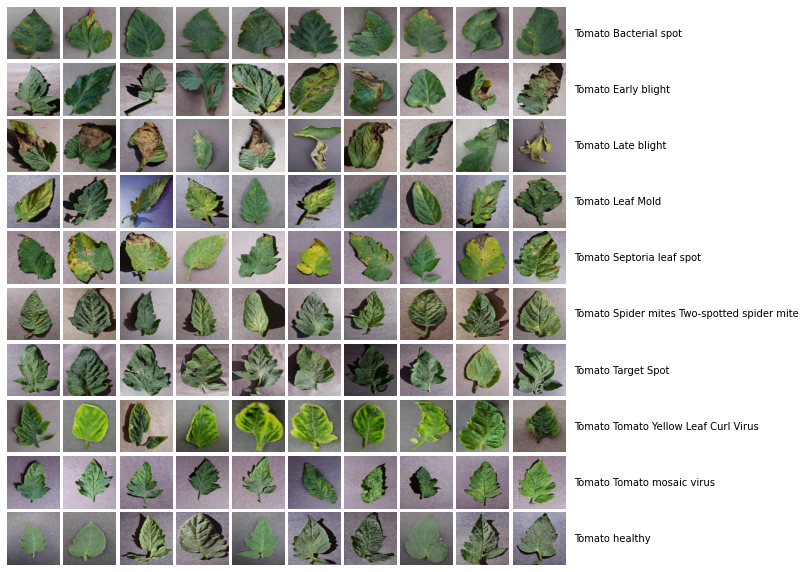

In [ ]:
num_classes = len (classes)
fig = plt.figure(1, figsize=(10, 40))
grid = ImageGrid(fig, 111, nrows_ncols = (num_classes, 10), axes_pad=0.05)

i = 0
for label, class_name in enumerate(classes):
  for filepath in df['file'][df['class_name']==class_name].values[:10]:
    ax = grid[i]
    img = read_img(filepath, (224, 224))
    ax.imshow(img/255.)
    ax.axis('off')
    if i % 10 == 10-1:
        name = format_name(filepath.split("/")[0])
        ax.text(260, 112, name, verticalalignment = 'center')
    i += 1
plt.show()

Train Test split

In [ ]:
import shutil
# Check whether the specified path exists or not
def move_file(file, train=False, valid=False,test=False):
  path = ''
  root_dir="/content/drive/MyDrive/4.2/project/plantvillage"
  if train:
    path ='/content/drive/MyDrive/4.2/final/train'
  elif valid:
    path = '/content/drive/MyDrive/4.2/final/valid'
  elif test:
    path = '/content/drive/MyDrive/4.2/final/test'
  else:
    return "No destination path"
    
  dest_path =f"{path}/{file.class_name}"
  isExist = os.path.exists(dest_path)
  if not isExist:
    os.makedirs(dest_path)
  file_path = f"{data_dir}/{file.file}"
  shutil.copy(file_path, f"{dest_path}")
  print(f"{file.class_name}/{file.file}: ----> {dest_path}")

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df,  test_size=0.2, random_state=42)

In [ ]:
train.shape[0], test.shape[0]

(11623, 2906)

In [ ]:
valid, test = train_test_split(test,  test_size=0.25, random_state=42)

In [ ]:
valid.shape[0], test.shape[0]

(2179, 727)

In [ ]:
train.apply(move_file, train=True, valid=False, test=False, axis=1)
valid.apply(move_file, train=False, valid=True, test=False, axis=1)
test.apply(move_file, train=False, valid=False, test=True, axis=1)

In [ ]:
from glob import glob
folders = glob("/content/drive/MyDrive/4.2/final/train/*")

In [ ]:
train_dir='/content/drive/MyDrive/4.2/final/train'
valid_dir= '/content/drive/MyDrive/4.2/final/valid'
test_dir= '/content/drive/MyDrive/4.2/final/test'

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf

In [ ]:
train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=25, 
  zoom_range = .1,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.2,
  fill_mode='nearest',
  brihtness_range = [0.5, 1.5],
  vertical_flip = True,
  horizontal_flip = True
)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(128, 128),
                                                 batch_size=16,
                                                 class_mode="categorical", shuffle=True)
valid_set = valid_datagen.flow_from_directory(valid_dir,
                                                 target_size=(128, 128),
                                                 batch_size=16,
                                                 class_mode="categorical", shuffle=False)

Found 11623 images belonging to 10 classes.
Found 2179 images belonging to 10 classes.


In [ ]:
SIZE = [128, 128]
vgg19 = VGG19(input_shape=SIZE + [3], weights="imagenet", include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg19.layers:
    layer.trainable = False
x = Flatten()(vgg19.output)
prediction = Dense(len(folders), activation="softmax")(x)

model = Model(inputs=vgg19.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_set, validation_data=valid_set, epochs=20, callbacks=[callback], verbose = 1, steps_per_epoch=200)
model.save('/content/drive/MyDrive/4.2/final/vgg19_model.h5')

Epoch 1/20
200/200 [==============================] - 1332s 7s/step - loss: 1.0265 - accuracy: 0.6731 - val_loss: 0.8097 - val_accuracy: 0.7494
Epoch 2/20
200/200 [==============================] - 1115s 6s/step - loss: 0.6549 - accuracy: 0.7853 - val_loss: 0.6723 - val_accuracy: 0.7737
Epoch 3/20
200/200 [==============================] - 1110s 6s/step - loss: 0.5395 - accuracy: 0.8154 - val_loss: 0.6497 - val_accuracy: 0.7669
Epoch 4/20
200/200 [==============================] - 1110s 6s/step - loss: 0.4820 - accuracy: 0.8406 - val_loss: 0.5727 - val_accuracy: 0.8137
Epoch 5/20
200/200 [==============================] - 1097s 5s/step - loss: 0.4217 - accuracy: 0.8618 - val_loss: 0.5793 - val_accuracy: 0.8022
Epoch 6/20
200/200 [==============================] - 1103s 6s/step - loss: 0.3856 - accuracy: 0.8716 - val_loss: 0.4667 - val_accuracy: 0.8458
Epoch 7/20
200/200 [==============================] - 1120s 6s/step - loss: 0.3304 - accuracy: 0.8884 - val_loss: 0.5251 - val_accuracy:

Training History

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

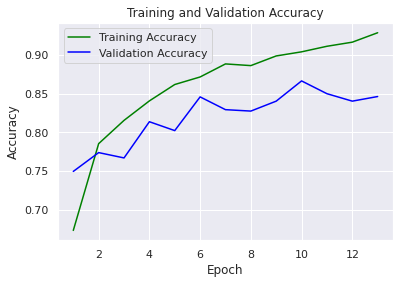

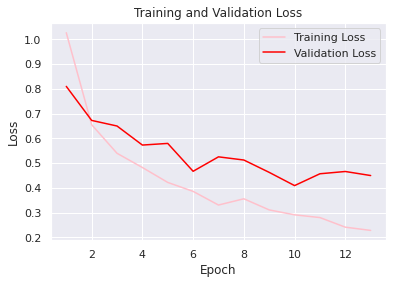

In [ ]:

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plt.show()

Prediction

In [ ]:
model_vgg19 = tf.keras.models.load_model('/content/drive/MyDrive/4.2/final/vgg19_model.h5')

In [ ]:
class_dict = {'Tomato___Bacterial_spot': 0,
         'Tomato___Early_blight': 1,
         'Tomato___Late_blight': 2,
         'Tomato___Leaf_Mold': 3,
         'Tomato___Septoria_leaf_spot': 4,
         'Tomato___Spider_mites Two-spotted_spider_mite': 5,
         'Tomato___Target_Spot': 6,
         'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
         'Tomato___Tomato_mosaic_virus': 8,
         'Tomato___healthy': 9}
def process_image(filepath):
    new_img = image.load_img(image_path, target_size=(128, 128))
    img = image.img_to_array(new_img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    return img


def prediction_cls(prediction):
  for key, clss in class_dict.items():
    if np.argmax(prediction) == clss:
      return key

In [ ]:
image_path = "/content/drive/MyDrive/images/Tomato___Bacterial_spot/0045ba29-ed1b-43b4-afde-719cc7adefdb___GCREC_Bact.Sp 6254.JPG"
img  = process_image(image_path)
img_pred = model_vgg19.predict(img)
disease = prediction_cls(img_pred)

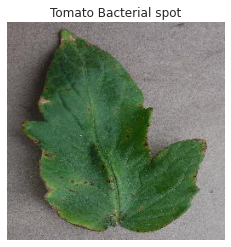

In [ ]:
#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(plt.imread(image_path))
plt.axis('off')
plt.title(format_name(disease))
plt.show()

Confusion Matrix

In [ ]:
Y_pred = model.predict(valid_set)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
class_dict = valid_set.class_indices
li = list(class_dict.keys())
print(li)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


Classsification Report

In [ ]:
import itertools

In [ ]:
cnf_matrix=confusion_matrix(valid_set.classes, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


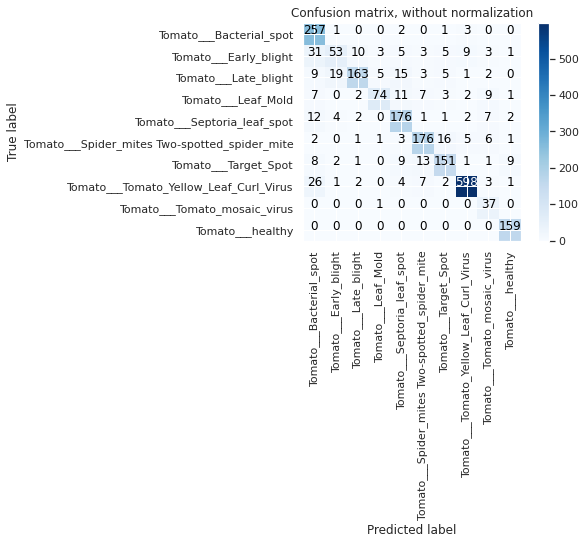

In [ ]:
plot_confusion_matrix(cnf_matrix, classes=li,
                      title='Confusion matrix, without normalization')

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(valid_set.classes, y_pred))

Confusion Matrix
[[257   1   0   0   2   0   1   3   0   0]
 [ 31  53  10   3   5   3   5   9   3   1]
 [  9  19 163   5  15   3   5   1   2   0]
 [  7   0   2  74  11   7   3   2   9   1]
 [ 12   4   2   0 176   1   1   2   7   2]
 [  2   0   1   1   3 176  16   5   6   1]
 [  8   2   1   0   9  13 151   1   1   9]
 [ 26   1   2   0   4   7   2 598   3   1]
 [  0   0   0   1   0   0   0   0  37   0]
 [  0   0   0   0   0   0   0   0   0 159]]


In [ ]:
print('Classification Report')
target_names =li
print(classification_report(valid_set.classes, y_pred, target_names=target_names))

Classification Report
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.73      0.97      0.83       264
                        Tomato___Early_blight       0.66      0.43      0.52       123
                         Tomato___Late_blight       0.90      0.73      0.81       222
                           Tomato___Leaf_Mold       0.88      0.64      0.74       116
                  Tomato___Septoria_leaf_spot       0.78      0.85      0.81       207
Tomato___Spider_mites Two-spotted_spider_mite       0.84      0.83      0.84       211
                         Tomato___Target_Spot       0.82      0.77      0.80       195
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.96      0.93      0.95       644
                 Tomato___Tomato_mosaic_virus       0.54      0.97      0.70        38
                             Tomato___healthy       0.91      1.00      0.95       159

                   

And then the evaluate:

In [ ]:
# evaluate model
score, accuracy = model.evaluate(valid_set, steps=len(valid_set), verbose=1)
print("Accuracy: " ,accuracy)
print("Loss: ", score)

137/137 [==============================] - 474s 3s/step - loss: 0.4495 - accuracy: 0.8463
Accuracy:  0.8462597727775574
Loss:  0.4495488107204437
Accuracy:  0.8462597727775574
Loss:  0.4495488107204437
